In [65]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

from BackDiffuse_LT import BackDiffuse

In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver



In [59]:
    # Core names of cores available
coreNames = ['Crete', 'SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG']

    # Selecting core name
coreName = 'SiteG'


In [60]:
d18OData = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/Alphabetd18O/'+coreName+'_det.txt',',')
densities = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDens/'+coreName+'DepthDens_w_Models.txt','\t')
diffLens = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/datasets/Alphabet_cores/AlphabetDiff/'+coreName+'_DepthDiff.txt','\t')
specsCores = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt',',')
specIdx = specsCores['CoreName'][specsCores['CoreName'] == coreName].index[0]

    # Set the specs for depth of Laki and Tambora eruptions for core
specsCore = specsCores.iloc[specIdx]
dTamb = np.float64(specsCore['dTamb'])
dLaki = np.float64(specsCore['dLaki'])

    # (FOR PLOTTING) Make array of only d18O data between Laki and Tamb
depth_LT = d18OData['depth'][(d18OData['depth'] >= dTamb) & (d18OData['depth'] <= dLaki)]
d18O_LT = d18OData['d18O'][(d18OData['depth'] >= dTamb) & (d18OData['depth'] <= dLaki)]

    # Create instance of back diffusion
inst = BackDiffuse(coreName, d18OData, specsCores, dTamb, dLaki, 32, diffLenData=diffLens[['Depth','sigma_o18']], densData=densities)

    # Make spectral estimate of diff len
diffLen = inst.spectralEstimate()

    # Make model/empiric estimate of diff len
difflenEstHL = inst.diffLenEstimateHL()

    # Compute final depth/d18O back diffused data w. final diff len and No. peaks
depth, data, diffLen, peaks = inst.backDiffused(print_Npeaks=False)


Starting sigma: 6.66 [cm]
Final sigma: 7.77 [cm]
Final # of peaks: 32


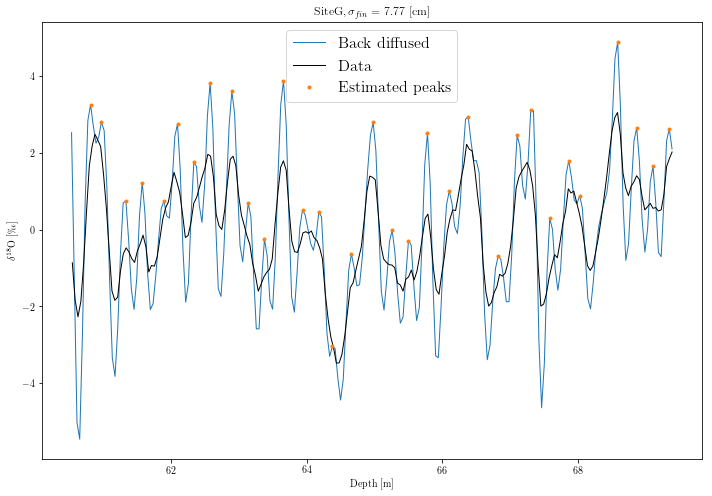

In [61]:

    # Plot original data, back diffused data and peak estimations
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(depth, data, lw=1, label='Back diffused')
ax.plot(depth_LT, d18O_LT-np.mean(d18O_LT),color='k', lw=1, label = 'Data')
ax.plot(depth[peaks], data[peaks],'.',lw=1, label='Estimated peaks')
ax.set(xlabel = 'Depth [m]', ylabel = '$\delta^{18}$O [\permil]', title=coreName+'$, \sigma_{fin} =$ ' + f'{diffLen*100:.2f} [cm]')
ax.legend(fontsize=16)
fig.tight_layout()
fig.savefig(coreName + '_peaks.jpg')



In [62]:
from scipy import interpolate

def interpCores(valMin, valMax, d_in, x_in, Delta_in):
    d = d_in[(d_in >= valMin) & (d_in <= valMax)]
    x = x_in[(d_in >= valMin) & (d_in <= valMax)]
    
    diff = np.diff(d)
    Delta = Delta_in
    
    d_min = Delta * np.ceil(d.values[0]/Delta)
    d_max = Delta * np.floor(d.values[-1]/Delta)

    n = int(1 + (d_max - d_min)/Delta)
    
    j_arr = np.linspace(0,n,n)
    dhat = d_min + (j_arr - 1)*Delta
    
    f = interpolate.CubicSpline(d,x)
    
    xhat = f(dhat)
    
    return dhat, xhat, Delta

In [63]:
dhat, xhat, Delta = interpCores(depth.min(), depth.max(), pd.Series(depth), pd.Series(data), 0.01)

In [64]:
from scipy import signal

peaks1 = signal.find_peaks(data)[0]
peaks_interp = signal.find_peaks(xhat)[0]



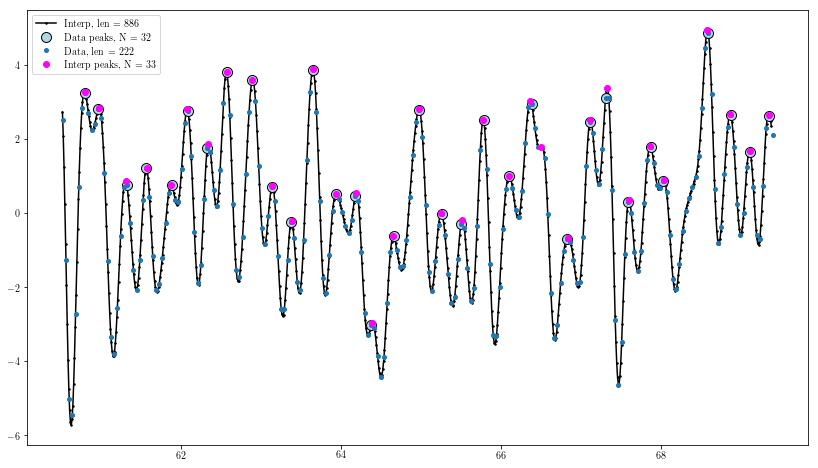

In [65]:
figInterp2, axInterp2 = plt.subplots(figsize=(14,8))

axInterp2.plot(dhat,xhat, '-', marker='.', ms=3, color='k',label=f'Interp, len = {len(dhat)}')
axInterp2.plot(depth[peaks1], data[peaks1], 'o', ms=10, markeredgecolor='k', color='lightblue', label=f'Data peaks, N = {len(data[peaks1])}')


axInterp2.plot(depth, data,'o', ms=4, label=f'Data, len = {len(depth)}')
axInterp2.plot(dhat[peaks_interp], xhat[peaks_interp], 'o', ms=6, color='magenta', label=f'Interp peaks, N = {len(xhat[peaks_interp])}')



axInterp2.legend()

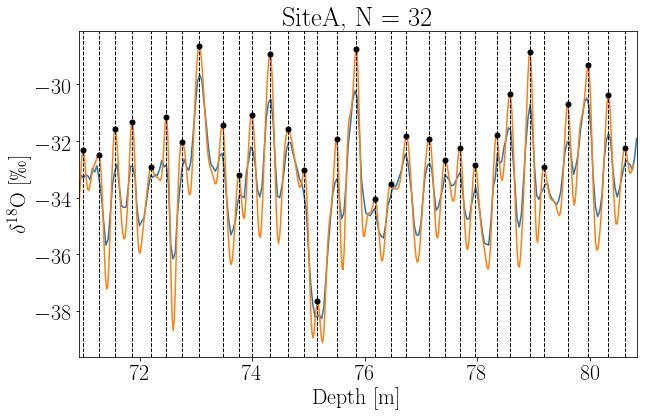

In [70]:
site = 'SiteA'

df = pd.read_csv('/home/thea/MesterTesen/Analysis/BackDiffusedSeries/'+site+'_BackDiffused', '\t')
depth = np.asarray(df['depth'])
data = np.asarray(df['d18O'])

depth_BD = np.asarray(df['depth_BD'])
data_BD = np.asarray(df['d18O_BD'])

from scipy import signal

peaks = sp.signal.find_peaks(data_BD)[0]

fig,ax = plt.subplots(figsize=(10,6))

ax.plot(depth,data)
ax.plot(depth_BD, data_BD)
ax.plot(depth_BD[peaks], data_BD[peaks],'.', ms=10,color='k')
ax.set(xlim=(min(depth_BD), max(depth)), xlabel='Depth [m]', ylabel='$\delta ^{18}$O [\permil]', title=site+f', N = {len(peaks)}');

for peak in peaks:
    ax.axvline(depth_BD[peak], color='k',ls='--',lw=1)


In [72]:
np.mean(np.diff(depth_BD[peaks]))

0.31069570100457106

In [25]:
d_deconC = np.asarray(df['depth_BD'])#dhat#depth
x_deconC = np.asarray(df['d18O_BD'] - np.mean(df['d18O_BD']))#xhat#data
depth = np.asarray(df['depth'])
data = np.asarray(df['d18O'] - np.mean(df['d18O']))

In [34]:
def ACF(x,y, m):
    mu = np.mean(y)
    sigma = np.std(y)
    
    n = len(y)
    maxLag = len(y)
    ks = np.arange(0,maxLag-1,1)
    S = np.zeros(len(ks))
    
    for k in ks:
        for i in range(1, n - k):
            S[k] += (y[i] - mu)*(y[i+k] - mu)
            
        S[k] *= 1/((n - k) * sigma**2)
        
    ks = ks# * (x[1] - x[0])
    
    return ks[ks < m], S[ks < m]

def cycleEst(x, y, m):
    
    ks, S = ACF(x,y,m)
    plt.plot(ks,S)
    l = []
    for i in range(2,len(S)):
        if (S[i-1] > S[i-2]) & (S[i] < S[i-1]) & (ks[i] < m_lim):
            l.append(ks[i])
    l = l[0]
    plt.axvline(x=l)
    return l



517


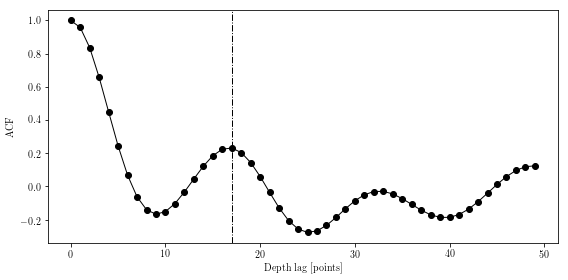

In [38]:
ks,S = ACF(d_deconC,x_deconC,50)
#ks,S = ACF(depth,data,20)

figACF, axACF = plt.subplots(figsize=(8,4))
axACF.plot(ks, S, 'o-', color='k',lw=1)
axACF.set(xlabel='Depth lag [points]', ylabel='ACF')
axACF.axvline(x=ks[17], color='k',ls='-.',lw=1)
figACF.tight_layout()

#saveFigs=True
#if saveFigs:
#    figACF.savefig('../WrittenWork/NovemberPresentation/figACF.eps')

In [40]:
def calcBounds(x, y, m, bounds_init):
    
    m_lim = m
    cycLen = np.zeros(len(bounds_init)-1)
    Ncycs = np.zeros(len(bounds_init)-1)
    
    for i in range(1,len(bounds_init)):
        idxMin = i-1
        idxMax = i

        x1 = x[(x > bounds_init[idxMin]) & (x <= bounds_init[idxMax])]
        y1 = y[(x > bounds_init[idxMin]) & (x <= bounds_init[idxMax])]

        cycLen[i-1] = cycleEst(x1, y1, m_lim)
        Ncycs[i-1] = len(x1)/cycLen[i-1]
     
    secPoints = cycLen*len(x)/sum(cycLen)
    secPoints = [int(N) for N in secPoints]
    
    cycPoints_tot = np.cumsum(secPoints)
    
    cycleSecBoundsNEW = np.append(x[0],x[cycPoints_tot])
    
    return cycLen, secPoints, cycleSecBoundsNEW, Ncycs



from itertools import groupby

def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)



def detBounds(x, y, m, bounds_init, cycLen_init, secPoints_init, Ncycs_init):
    cycLen = cycLen_init
    bounds = bounds_init
    secPoints = secPoints_init
    Ncycs = Ncycs_init
    i = 0
    
    m_lim = m
    while i < 1000:
        print(Ncycs.round(0))
        if not all_equal(Ncycs.round(0)):
            
            
            print(i)
            bounds_in = bounds
            cycLen, secPoints, bounds, Ncycs = calcBounds(x,y, m_lim, bounds_in)
            
            i += 1
        else:
            return bounds, secPoints, Ncycs



In [47]:
N_secs = 5

cycleSecBounds = np.linspace(d_deconC.min(), d_deconC.max(), N_secs+1)#np.append(np.arange(d_deconC.min(), d_deconC.max(),cycleSec_len), d_deconC.max())

m_lim = N_secs*50

103
103
103
103
104
[6. 6. 6. 6. 5.]
0
98
104
104
92
116
[6. 6. 6. 5. 6.]
1
97
103
103
103
109
[6. 6. 5. 6. 6.]
2
97
103
109
97
109
[6. 6. 6. 6. 6.]


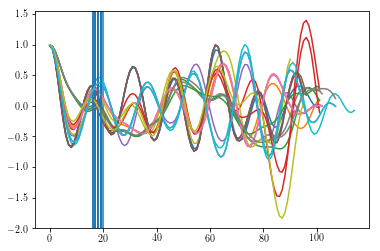

In [48]:
cycLen_init, secPoints_init, bounds_init, Ncycs_init = calcBounds(d_deconC,x_deconC, m_lim, cycleSecBounds)

boundsFin, NsFin, nCsFin =detBounds(d_deconC, x_deconC, m_lim, bounds_init, cycLen_init, secPoints_init, Ncycs_init)

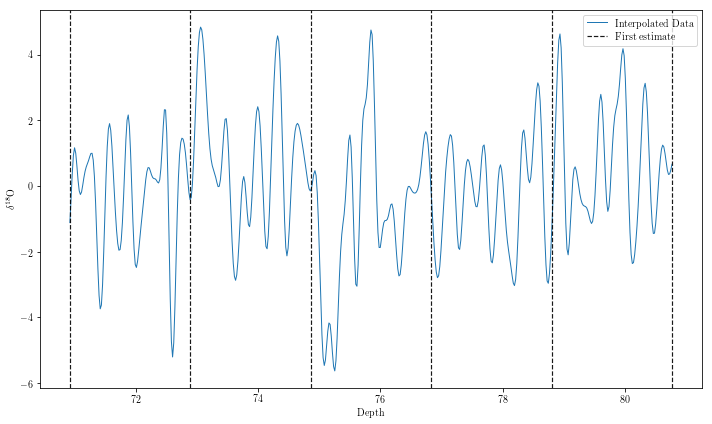

In [49]:
figSignal, axSignal = plt.subplots(figsize=(10,6))
axSignal.plot(d_deconC, x_deconC, label='Interpolated Data',lw=1)
axSignal.set(xlabel='Depth', ylabel='$\delta^{18}$O')
for bound in cycleSecBounds:
    axSignal.axvline(x=bound,color='k',ls='--',lw=1.2,alpha=0.9, label='First estimate')
    
#for i in range(len(boundsFin)):

#    axSignal.axvline(x=boundsFin[i],color='k',lw=1.6, label='Final estimate')
axSignal.legend()
figSignal.tight_layout()


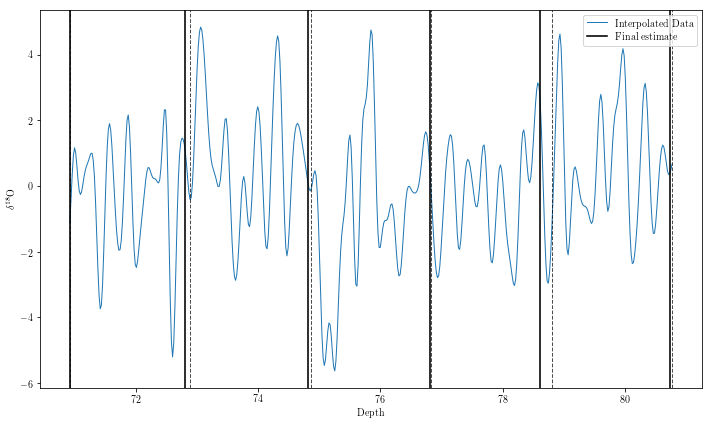

In [50]:
figSignal1, axSignal1 = plt.subplots(figsize=(10,6))
axSignal1.plot(d_deconC, x_deconC, label='Interpolated Data',lw=1)
axSignal1.set(xlabel='Depth', ylabel='$\delta^{18}$O')
for bound in cycleSecBounds:
    axSignal1.axvline(x=bound,color='k',ls='--',lw=1,alpha=0.7)
    
for i in range(len(boundsFin)):

    axSignal1.axvline(x=boundsFin[i],color='k',lw=1.6, label='Final estimate')
axSignal1.legend()

figSignal1.tight_layout()



In [51]:
d_secs = []
x_secs = []
Ns_secs = []
nPointsInCycs = []
nPointsInCyc = NsFin/nCsFin

points = np.diff(NsFin)
for i in range(1,N_secs+1):
    dMin = boundsFin[i-1]
    dMax = boundsFin[i]
    
    d_secs.append(d_deconC[(d_deconC >= dMin) & (d_deconC < dMax)])
    x_secs.append(x_deconC[(d_deconC >= dMin) & (d_deconC < dMax)])
    Ns = len(x_deconC[(d_deconC >= dMin) & (d_deconC < dMax)])
    Ns_secs.append(np.ones(Ns) * Ns)
    
    nPointsInCycs.append(np.ones(Ns))
    
Ns_secs = np.concatenate(Ns_secs)


d_secs = np.concatenate(d_secs)
x_secs = np.concatenate(x_secs)

nPointsInCycs = np.concatenate(nPointsInCycs*nPointsInCyc)
#len(d_deconC)

In [52]:
mus = np.zeros(len(d_secs))
x_secsT = np.concatenate([np.zeros(int(nPointsInCyc[0]/2)), x_secs,np.zeros(int(nPointsInCyc[-1]/2))])


In [53]:
xStart = int(nPointsInCyc[0]/2)
xEnd = int(len(x_secsT) - nPointsInCyc[-1]/2)

mus = np.zeros(len(d_secs))
sigmas = np.zeros(len(d_secs))

for i in range(xStart+1,xEnd):
    li = nPointsInCycs[i-xStart]
    sumStart = int(i - li/2)
    sumEnd = int(i+li/2)
    #print(f'Start:{sumStart}')
    #print(li)
    #print(f'Slut:{sumEnd}\n')
    mus[i-xStart-1] = sum(x_secsT[sumStart:sumEnd]/(li+1))
    sigmas[i-xStart-1] = sum((x_secsT[sumStart:sumEnd] - mus[i-xStart-1])**2/(li+1))

33


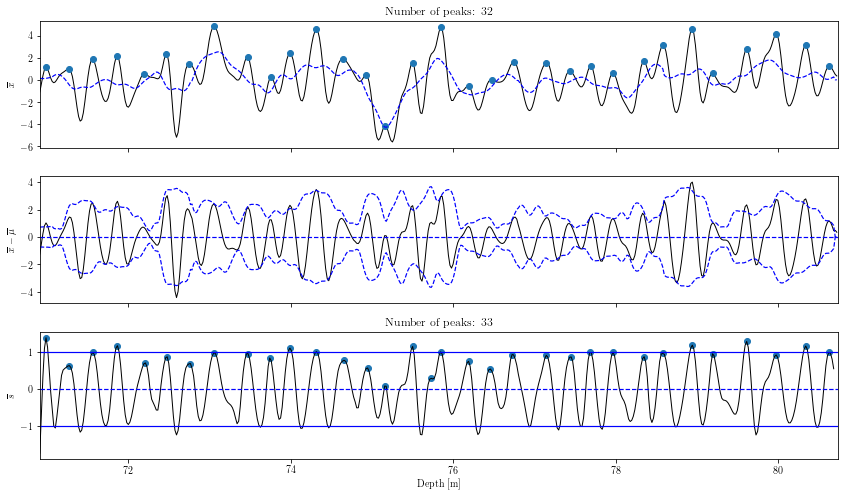

In [54]:
from scipy import signal
d_peaks = signal.find_peaks(x_secs)[0]


fig,ax = plt.subplots(3,1,figsize=(12,7), sharex=True)
ax[0].plot(d_secs,x_secs,color='k',lw=1)
ax[0].plot(d_secs[d_peaks],x_secs[d_peaks], 'o')
ax[0].plot(d_secs,mus,color='blue',ls='--', lw=1.2)
ax[0].set(xlim=(boundsFin[0],boundsFin[-1]), ylabel='$\overline{x}$', title=f'Number of peaks: {len(d_peaks)}')#(70.90,80.85))#

#ax[1].plot(d_secs,x_secs)
ax[1].plot(d_secs,x_secs-mus,color='k',lw=1)
ax[1].axhline(y=0,color='blue', ls='--', lw=1.2)
ax[1].plot(d_secs, np.sqrt(2)*np.sqrt(sigmas),color='blue',ls='--', lw=1.2)
ax[1].plot(d_secs, -np.sqrt(2)*np.sqrt(sigmas),color='blue',ls='--', lw=1.2)
ax[1].set(ylabel='$\overline{x} - \overline{\mu}$')


s = (x_secs[:-2]-mus[:-2])/(np.sqrt(2)*np.sqrt(sigmas[:-2]))



S_peaks = signal.find_peaks(s)[0]

ax[2].plot(d_secs[:-2][S_peaks],s[S_peaks], 'o')
ax[2].plot(d_secs[:-2],s, color='k', lw=1)
ax[2].axhline(y=0,color='blue', ls='--', lw=1.2)
ax[2].axhline(y=-1,color='blue', lw=1.2)
ax[2].axhline(y=1,color='blue', lw=1.2)
ax[2].set(ylabel='$\overline{s}$', xlabel='Depth [m]',title=f'Number of peaks: {len(S_peaks)}')
fig.tight_layout()
#ax[2].plot(d_secs,x_secs,lw=1)
print(len(S_peaks))

Number of cycles in each section: 6.42


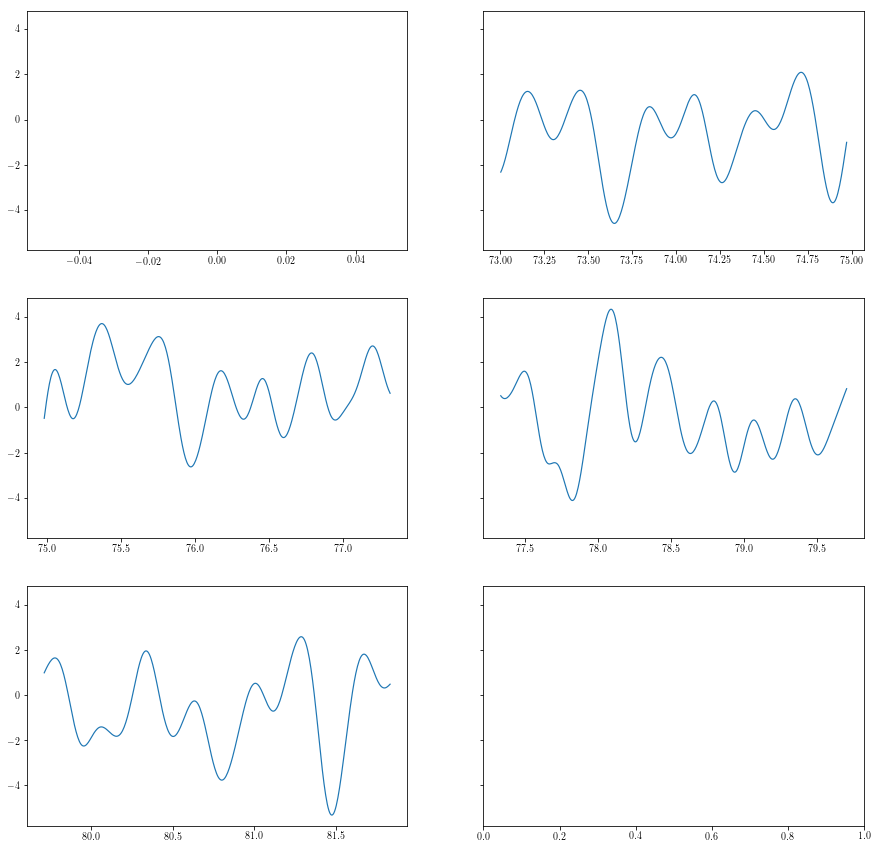

In [22]:

figSignal, axSignal = plt.subplots(int(np.ceil(N_secs/2)),2,figsize=(15,15),sharey=True)

for ax,i in zip(axSignal.flatten(), range(N_secs)):
    dMin = boundsFin[i-1]
    dMax = boundsFin[i]
    ax.plot(d_deconC[(d_deconC > dMin) & (d_deconC < dMax)], x_deconC[(d_deconC > dMin) & (d_deconC < dMax)], label='Deconvoluted Data', lw=1.2)
print(f'Number of cycles in each section: {nCsFin[0]:.2f}')

In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse
from GetCoreData_fct import GetCoreData



from Interpolation_Class import Interpolation

In [3]:
CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


In [4]:
sites = ['Crete', 'SiteA', 'SiteB', 'SiteE', 'SiteG']

In [5]:
site = 'SiteA'

core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']


DataAll = GetCoreData(site)

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [45]:
inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, 32, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)
diffLen = inst.spectralEstimate()
difflenEstHL = inst.diffLenEstimateHL()
depth1, data, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True, newDelta=0.01)


Starting sigma: 5.52 [cm]
Final sigma: 6.14 [cm]
Final # of peaks: 32
Delta: 0.038
Delta new: 0.010


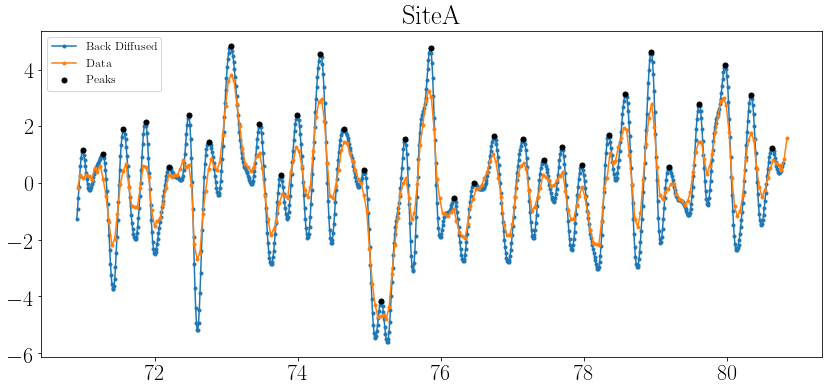

In [46]:
fig, ax = plt.subplots(figsize=(14,6))

plt.plot(depth1,data, '-', marker='.',label='Back Diffused')
plt.plot(data_d18O_LT['depth'], data_d18O_LT['d18O']- np.mean(data_d18O_LT['d18O']),'-',marker='.', label='Data')
plt.plot(depth1[peaks],data[peaks],'.', color='k', ms=10, label='Peaks')
plt.title(site)
plt.legend(fontsize=12)


In [47]:
N = len(data)
delta = depth1[1]-depth1[0]

DCT = sp.fft.dct(data, 2, n = N, norm='ortho')
PSD = abs(DCT)**2
freq = np.fft.fftfreq(2*N, delta)[:(2*N)//2]


In [48]:
def ACF(x,y, m):
    mu = np.mean(y)
    sigma = np.std(y)
    n = len(y)
    maxLag = len(y)
    ks = np.arange(0,maxLag-1,1)
    
    S = np.zeros(len(ks))
    
    for k in ks:
        for i in range(1, n - k):
            S[k] += (y[i] - mu)*(y[i+k] - mu)
            
        S[k] *= 1/((n - k) * sigma**2)
        
    ks = ks# * (x[1] - x[0])
    
    return ks[ks < m], S[ks < m]

def cycleEst(x, y, m):
    
    ks, S = ACF(x,y,m)
    plt.plot(ks,S)
    l = []
    for i in range(2,len(S)):
        if (S[i-1] > S[i-2]) & (S[i] < S[i-1]) & (ks[i] < m_lim):
            l.append(ks[i])
    l = l[0]
    plt.axvline(x=l)
    return l



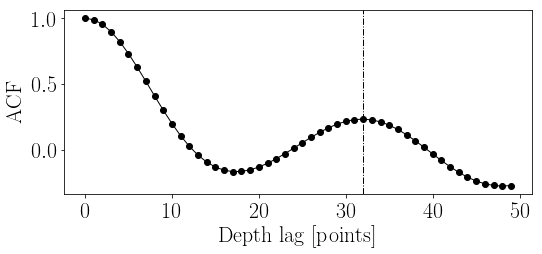

In [52]:
ks,S = ACF(depth1,data,50)

figACF, axACF = plt.subplots(figsize=(8,4))
axACF.plot(ks, S, 'o-', color='k',lw=1)
axACF.set(xlabel='Depth lag [points]', ylabel='ACF')

axACF.axvline(x=ks[32], color='k',ls='-.',lw=1)

figACF.tight_layout()